#السلام عليكم
####This is the fine-tunning nootbook i made, fell free to add any improvemnt.
##### This architecture works in this way: the encoder will scan an image(the screen of the user), in this notebook I took the (x,y) coordinates and transform them into images for our ViT to be trained on. you may ask why i didn't use the images provided in the dataset(pix2pix folder). The decoder needs the (x,y) reprsintion of the Calligraphy for it to understand each stroke, without the (x,y) coordinates, the process would be static. We want the decoder to understand the perfect way to move your hand. and if we used a different dataset for the encoder and the decoder that would cause trouble. the econder would provid a vector,let's say the vector is the student trying to write احمد in rug'ah; the encoder would vectorize it([0.5, 0.3, 0.2]), that vector would be feature represention of احمد. Then the decoder would take that vector it would look into its own weights. To try and look for the perfect way to wirte احمد in Rug'ah, and it would from how to write أ to how to write د, it will move like a Calligraphy experet. so if we train the encoder in a diffrent dataset. the احمد it vectorize the encoder would catch it as احمد; that's way we need to train them in the same dataset.

## use google colab pro to run this, you need atleast 16gb of memory. So use A100 or T4.
### I didn't test the decoder, I'm currently fine-tuning it, it would about 6h to finish. If you have access to A100, you may fine-tune it yourself. I used up my time on A100 and currently don't have access to it

In [1]:
# Cell 1: Mount Drive and Set Up Project
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create the project folder
project_path = "/content/drive/MyDrive/AI_Calligraphy_Tutor"
os.makedirs(project_path, exist_ok=True)
os.chdir(project_path)
print(f"Project folder is ready at: {os.getcwd()}")

Mounted at /content/drive
Project folder is ready at: /content/drive/MyDrive/AI_Calligraphy_Tutor


In [4]:
# Cell 2: Install Dependencies
!pip install fastapi uvicorn[standard] python-multipart torch transformers timm opencv-python-headless numpy Pillow pyngrok --quiet
!pip install "accelerate>=0.21.0" "peft>=0.4.0" "bitsandbytes>=0.40.2" "trl>=0.4.7" "safetensors>=0.3.1" "tqdm" "scikit-learn" "arabic_reshaper" "python-bidi" --quiet

print("\nAll dependencies have been installed successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.8/459.8 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
# Cell 3: Download and Prepare the Dataset
import os

if not os.path.exists('dataset'):
    !wget -O calliar.zip https://github.com/ARBML/Calliar/raw/refs/heads/main/calliar_dataset/dataset.zip
    !unzip -q calliar.zip -d .
    !mv calliar_dataset dataset
    !rm calliar.zip
    print("\nCalliar dataset downloaded and unzipped.")
else:
    print("\nCalliar dataset already exists.")

--2025-08-06 13:22:43--  https://github.com/ARBML/Calliar/raw/refs/heads/main/calliar_dataset/dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ARBML/Calliar/refs/heads/main/calliar_dataset/dataset.zip [following]
--2025-08-06 13:22:43--  https://raw.githubusercontent.com/ARBML/Calliar/refs/heads/main/calliar_dataset/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53774774 (51M) [application/zip]
Saving to: ‘calliar.zip’

calliar.zip         100%[===================>]  51.28M   132MB/s    in 0.4s    

2025-08-06 13:22:44 (132 MB/s) - ‘calliar.zip’ saved [53774774/537747

In [6]:
# Cell 4: Create the Image Processor Script
%%writefile image_processor.py
import cv2
import numpy as np
from PIL import Image

IMAGE_SIZE = (224, 224)
IMAGE_PADDING = 20
STROKE_THICKNESS = 3

def stroke_to_image(json_data):
    """
    Converts a list of strokes from the Calliar JSON data into a clean, rasterized image.
    This definitive version correctly handles the nested [{char:[[x,y],...]},...] format.
    """
    canvas = np.zeros(IMAGE_SIZE, dtype=np.uint8)
    all_points_list = []

    if isinstance(json_data, list):
        for char_dict in json_data:
            if isinstance(char_dict, dict):
                for stroke_list in char_dict.values():
                    if isinstance(stroke_list, list):
                        for point in stroke_list:
                            if isinstance(point, list) and len(point) == 2:
                                all_points_list.append(point)

    if not all_points_list:
        return Image.fromarray(canvas).convert("RGB")

    all_points = np.array(all_points_list, dtype=np.float32)
    min_c, max_c = all_points.min(axis=0), all_points.max(axis=0)

    if np.allclose(min_c, max_c):
        scale = 1.0
    else:
        scale = min((np.array(IMAGE_SIZE) - IMAGE_PADDING * 2) / ((max_c - min_c) + 1e-6))

    if isinstance(json_data, list):
        for char_dict in json_data:
            if isinstance(char_dict, dict):
                for stroke_to_draw in char_dict.values():
                    if isinstance(stroke_to_draw, list) and stroke_to_draw:
                        valid_points = [p for p in stroke_to_draw if isinstance(p, (list, tuple)) and len(p) == 2]
                        if not valid_points: continue

                        points = ((np.array(valid_points, dtype=np.float32) - min_c) * scale).astype(np.int32) + IMAGE_PADDING
                        cv2.polylines(canvas, [points], isClosed=False, color=(255), thickness=STROKE_THICKNESS, lineType=cv2.LINE_AA)

    return Image.fromarray(canvas).convert("RGB")

print("image_processor.py created successfully.")

Writing image_processor.py


In [15]:
# Cell 5: Create the Encoder Training Script
%%writefile train_encoder.py
import os, json, torch, numpy as np
from torch.utils.data import Dataset
from transformers import ViTImageProcessor, ViTForImageClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from image_processor import stroke_to_image

# Hyper prameters
VIT_MODEL_NAME = "google/vit-large-patch16-224-in21k"
DATASET_PATH = "dataset"
MODEL_OUTPUT_DIR = "calligraphy_encoder_v1"
NUM_EPOCHS = 15
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

class CalligraphyClassificationDataset(Dataset):
    def __init__(self, data_path, processor, label_encoder, mode="train"):
        self.processor = processor
        self.label_encoder = label_encoder
        self.samples = []
        subset_path = os.path.join(data_path, mode)
        for filename in os.listdir(subset_path):
            if filename.endswith(".json"):
                self.samples.append({"path": os.path.join(subset_path, filename), "label": filename.split('_')[0]})

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        with open(sample["path"], 'r', encoding='utf-8') as f:
            data = json.load(f)
        image = stroke_to_image(data)
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values
        try:
            label_id = self.label_encoder.transform([sample["label"]])[0]
        except ValueError:
            return self.__getitem__(np.random.randint(0, len(self)))
        return {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(label_id)}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

def main():
    print("--- Stage 1: Training ViT Encoder ---")
    all_labels = set()
    for folder in ['train', 'valid', 'test']:
        folder_path = os.path.join(DATASET_PATH, folder)
        if os.path.isdir(folder_path):
            all_labels.update([f.split('_')[0] for f in os.listdir(folder_path) if f.endswith('.json')])

    label_encoder = LabelEncoder().fit(list(all_labels))
    num_labels = len(label_encoder.classes_)
    print(f"Found {num_labels} unique labels across all datasets.")

    processor = ViTImageProcessor.from_pretrained(VIT_MODEL_NAME)
    model = ViTForImageClassification.from_pretrained(VIT_MODEL_NAME, num_labels=num_labels, ignore_mismatched_sizes=True)

    train_dataset = CalligraphyClassificationDataset(DATASET_PATH, processor, label_encoder, mode="train")
    eval_dataset = CalligraphyClassificationDataset(DATASET_PATH, processor, label_encoder, mode="valid")

    training_args = TrainingArguments(
        output_dir=MODEL_OUTPUT_DIR,
        per_device_train_batch_size=BATCH_SIZE,
        num_train_epochs=NUM_EPOCHS,
        fp16=True,
        save_strategy="steps",
        eval_strategy="steps",
        eval_steps=100,
        save_steps=100,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        save_total_limit=3,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    trainer.save_model(MODEL_OUTPUT_DIR)
    processor.save_pretrained(MODEL_OUTPUT_DIR)
    print(f"ViT Encoder fine-tuned and saved to '{MODEL_OUTPUT_DIR}'")

if __name__ == "__main__":
    main()

Overwriting train_encoder.py


In [ ]:
!python train_encoder.py

--- Displaying Random Samples ---


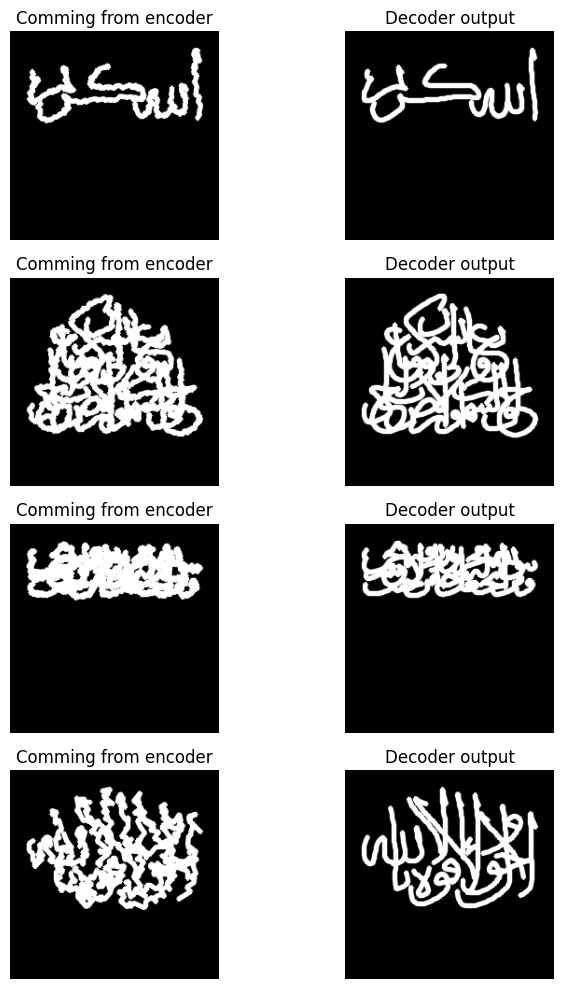

In [17]:
# Cell for visualizing the cycle of the models.
import os
import json
import random
import copy
import matplotlib.pyplot as plt
from image_processor import stroke_to_image

DATASET_PATH = "dataset"
NUM_SAMPLES_TO_SHOW = 4

def add_noise_to_stroke(json_data, noise_level=5):
    """
    Takes the raw JSON data, creates a deep copy, and adds noise to the coordinates.
    This version correctly handles the complex [{char:[[x,y],...]},...] structure.
    """
    noisy_data = copy.deepcopy(json_data) # Create a copy to avoid modifying the original

    if isinstance(noisy_data, list):
        for char_dict in noisy_data:
            if isinstance(char_dict, dict):
                for stroke_list in char_dict.values():
                    if isinstance(stroke_list, list):
                        for point in stroke_list:
                            if isinstance(point, list) and len(point) == 2:
                                try:
                                    point[0] += random.randint(-noise_level, noise_level)
                                    point[1] += random.randint(-noise_level, noise_level)
                                except (ValueError, TypeError):
                                    continue
    return noisy_data

def view_mamba_training_data():
    print("--- Displaying Random Samples ---")

    train_folder_path = os.path.join(DATASET_PATH, 'train')
    train_files = [f for f in os.listdir(train_folder_path) if f.endswith('.json')]
    if not train_files:
        print(" No files found in the train set.")
        return

    random_samples = random.sample(train_files, min(NUM_SAMPLES_TO_SHOW, len(train_files)))

    plt.figure(figsize=(8, 10))

    plot_index = 1
    for sample_file in random_samples:
        sample_path = os.path.join(train_folder_path, sample_file)

        with open(sample_path, 'r', encoding='utf-8') as f:
            perfect_stroke_data = json.load(f)

        noisy_stroke_data = add_noise_to_stroke(perfect_stroke_data)

        perfect_image = stroke_to_image(perfect_stroke_data)
        noisy_image = stroke_to_image(noisy_stroke_data)

        plt.subplot(NUM_SAMPLES_TO_SHOW, 2, plot_index)
        plt.imshow(noisy_image)
        plt.title("Comming from encoder")
        plt.axis('off')
        plot_index += 1

        plt.subplot(NUM_SAMPLES_TO_SHOW, 2, plot_index)
        plt.imshow(perfect_image)
        plt.title("Decoder output")
        plt.axis('off')
        plot_index += 1

    plt.tight_layout()
    plt.show()

view_mamba_training_data()

In [20]:
# Cell 7: Create the Decoder Training Script
%%writefile train_decoder.py
import os, json, torch, random, glob, copy
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, MambaForCausalLM
from tqdm.auto import tqdm

# Hyper parmeters
MAMBA_MODEL_NAME = "state-spaces/mamba-130m-hf"
TOKENIZER_NAME = "gpt2"
DATASET_PATH = "dataset"
MODEL_OUTPUT_DIR = "calligraphy_decoder_v1"
NUM_EPOCHS = 3
BATCH_SIZE = 4
LEARNING_RATE = 5e-5
MAX_LENGTH = 256

def add_noise_to_stroke(json_data, noise_level=5):
    noisy_data = copy.deepcopy(json_data)
    if isinstance(noisy_data, list):
        for char_dict in noisy_data:
            if isinstance(char_dict, dict):
                for stroke_list in char_dict.values():
                    if isinstance(stroke_list, list):
                        for point in stroke_list:
                            if isinstance(point, list) and len(point) == 2:
                                try:
                                    point[0] += random.randint(-noise_level, noise_level)
                                    point[1] += random.randint(-noise_level, noise_level)
                                except (ValueError, TypeError):
                                    continue
    return noisy_data

class CalligraphyDenoisingDataset(Dataset):
    def __init__(self, data_path, tokenizer, max_length, mode="train"):
        self.tokenizer = tokenizer; self.max_length = max_length; self.samples = []
        subset_path = os.path.join(data_path, mode)
        json_files = glob.glob(os.path.join(subset_path, "*.json"))

        for filepath in tqdm(json_files, desc=f"Loading '{mode}' data"):
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    perfect_strokes_json = json.load(f)
                if not isinstance(perfect_strokes_json, list) or not perfect_strokes_json:
                    continue
                noisy_strokes_json = add_noise_to_stroke(perfect_strokes_json)
                perfect_str = " ".join([f"{int(p[0])},{int(p[1])}" for d in perfect_strokes_json for s in d.values() for p in s])
                noisy_str = " ".join([f"{int(p[0])},{int(p[1])}" for d in noisy_strokes_json for s in d.values() for p in s])
                if perfect_str and noisy_str:
                    self.samples.append({"input_text": noisy_str, "target_text": perfect_str})
            except Exception:
                continue
        print(f"Loaded {len(self.samples)} valid samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        input_encodings = self.tokenizer(sample["input_text"], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        target_encodings = self.tokenizer(sample["target_text"], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        labels = target_encodings.input_ids
        labels[labels == self.tokenizer.pad_token_id] = -100
        return {"input_ids": input_encodings.input_ids.squeeze(), "attention_mask": input_encodings.attention_mask.squeeze(), "labels": labels.squeeze()}

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"--- Stage 2: Training Mamba Decoder on {device} ---")

    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
    tokenizer.pad_token = tokenizer.eos_token

    model = MambaForCausalLM.from_pretrained(MAMBA_MODEL_NAME, ignore_mismatched_sizes=True)
    model.resize_token_embeddings(len(tokenizer))

    train_dataset = CalligraphyDenoisingDataset(DATASET_PATH, tokenizer, max_length=MAX_LENGTH, mode="train")
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model.to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()

    model.train()
    for epoch in range(NUM_EPOCHS):
        print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        progress_bar = tqdm(train_dataloader, desc="Training")
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            with torch.cuda.amp.autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            progress_bar.set_postfix({"loss": loss.item()})

    model.save_pretrained(MODEL_OUTPUT_DIR)
    tokenizer.save_pretrained(MODEL_OUTPUT_DIR)
    print(f"Mamba Decoder fine-tuned and saved to '{MODEL_OUTPUT_DIR}'")

if __name__ == "__main__":
    main()

Overwriting train_decoder.py


In [ ]:
!python train_decoder.py
